In [ ]:
import numpy as np
import PIL.Image as Image
import PIL
from matplotlib import pylab as P
import torch
from torchvision import models, transforms
import math
from scipy import ndimage

In [ ]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    im = np.transpose(im, (1,2,0))
    P.axis('off')
    P.imshow(im)
    P.title(title)
    P.show()

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def VisualizeImageGrayscale(image_3d, percentile=99):
  image_2d = np.sum(np.abs(image_3d), axis=2)
  vmax = np.percentile(image_2d, percentile)
  vmin = np.min(image_2d)
  return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)

In [ ]:
def load_preprocess (name = "inceptionv3"):
    if(name == "resnet50v2" or name == "resnet101v2" or name == "resnet152v2" or name == "inceptionv3" or name == "mobilenetv2" or name == "vgg16" or name == "vgg19" or name == "densenet121" or name == "densenet169" or name == "densenet201"):
        def PreprocessImages(images):
            transformer = transforms.Compose([
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
            images = torch.tensor(images, dtype = torch.float32)
            images = transformer(images)
            return images.requires_grad_(True)
        return PreprocessImages
def load_model(name = "inceptionv3"):
    model = None
    if(name == "resnet50v2"):
        model = models.resnet50(weights='IMAGENET1K_V2').cuda()
    if(name == "resnet101v2"):
        model = models.resnet101(weights='IMAGENET1K_V2').cuda()
    if(name == "resnet151v2"):
        model = models.resnet152(weights='IMAGENET1K_V2').cuda()
    if(name == "inceptionv3"):
        model = models.inception_v3(weights='IMAGENET1K_V1', init_weights=False).cuda()
    if(name == "mobilenetv2"):
        model = models.mobilenet_v2(weights='IMAGENET1K_V2').cuda()
    if(name == "vgg16"):
        model = models.vgg16(weights='IMAGENET1K_V1').cuda()
    if(name == "vgg19"):
        model = models.vgg19(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet121"):
        model = models.densenet121(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet169"):
        model = models.densenet169(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet201"):
        model = models.densenet201(weights='IMAGENET1K_V1').cuda()
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    model.zero_grad()
    return model
def load_image(name = "inceptionv3"):
    if(name == "resnet50v2" or name == "resnet101v2" or name == "resnet152v2" or name == "mobilenetv2"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(232),
                    transforms.CenterCrop(224)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
    if(name == "inceptionv3"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(342),
                    transforms.CenterCrop(299)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
    if(name == "vgg16" or name == "vgg19" or name == "densenet121" or name == "densenet169" or name == "densenet201"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(256),
                    transforms.CenterCrop(224)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
def init (name = "inceptionv3"):
    return(load_model(name), load_image(name), load_preprocess(name))

In [ ]:
class BlurIG:
    def __init__(self, model, preprocess, load):
        self.model = model
        self.load = load
        self.preprocess = preprocess
    def saliency(self, x_values_paths, prediction_class, steps=20, steps_at=None, batch_size=32, max_sigma = 50, grad_step=0.01, sqrt=False):
        x_values = self.load(x_values_paths)
        x_values = x_values*255
        if sqrt:
            sigmas = [math.sqrt(float(i)*max_sigma/float(steps)) for i in range(0, steps+1)]
        else:
            sigmas = [float(i)*max_sigma/float(steps) for i in range(0, steps+1)]
        step_vector_diff = [sigmas[i+1] - sigmas[i] for i in range(0, steps)]

        if steps_at is None:
            steps_at = [steps]

        blurign = torch.zeros((len(steps_at), x_values.shape[0], x_values.shape[1], x_values.shape[2], x_values.shape[3]))
        blurigidgin = torch.zeros((len(steps_at), x_values.shape[0], x_values.shape[1], x_values.shape[2], x_values.shape[3]))

        def gaussian_blur(images, sigma):
            if sigma == 0:
                return torch.from_numpy(images).cuda()
            return transforms.GaussianBlur(2*round(4*sigma)+1, sigma).forward(torch.from_numpy(images).cuda())

        def reshape_fortran(x, shape):
            if len(x.shape) > 0:
                x = x.permute(*reversed(range(len(x.shape))))
            return x.reshape(*reversed(shape)).permute(*reversed(range(len(shape))))

        for k in range(0,x_values.shape[0],batch_size):
            k1 = k*batch_size
            k2 = np.min([(k+1)*batch_size, x_values.shape[0]])
            if (k1 >= k2):
                break

            x_value = x_values[k1:k2]
            x_step_batched = []
            gaussian_gradient_batched = []
            gaussian_gradientn = torch.zeros((steps, x_value.shape[0], x_value.shape[1], x_value.shape[2], x_value.shape[3]))
            gradientsn = torch.zeros((steps, x_value.shape[0], x_value.shape[1], x_value.shape[2], x_value.shape[3]))
            outputsn = torch.zeros((steps, x_value.shape[0]))

            for i in range(steps):
                x_step = gaussian_blur(x_value, sigmas[i])
                gaussian_gradient = (gaussian_blur(x_value,sigmas[i]+grad_step)-x_step)/grad_step
                x_step_batched.append(x_step)
                gaussian_gradient_batched.append(gaussian_gradient)
                gaussian_gradientn[i] = gaussian_gradient

                if len(x_step_batched)*(x_value.shape[0]) >= batch_size or i == steps - 1:
                    x_step_batched = torch.stack(x_step_batched)
                    gaussian_gradient_batched = torch.stack(gaussian_gradient_batched)
                    x_step_batch = torch.reshape(torch.swapaxes(x_step_batched, 0, 1), (x_step_batched.shape[0]*x_step_batched.shape[1], x_step_batched.shape[2], x_step_batched.shape[3], x_step_batched.shape[4]))
                    x_step_batch = x_step_batch/255
                    processed = self.preprocess(x_step_batch)
                    target_class_idx = np.repeat(prediction_class[k1:k2],x_step_batched.shape[0])
                    output = self.model(processed)
                    m = torch.nn.Softmax(dim=1)
                    output = m(output)
                    outputs = output[torch.arange(x_step_batch.shape[0]),target_class_idx]
                    gradientsf = torch.autograd.grad(outputs, processed, grad_outputs=torch.ones_like(outputs))[0].detach()
                    outputs = reshape_fortran(outputs,(x_step_batched.shape[0], x_step_batched.shape[1])).detach()
                    outputsn[i-x_step_batched.shape[0]+1:i+1] = outputs
                    gradientsf = reshape_fortran(gradientsf, (x_step_batched.shape[0], x_step_batched.shape[1], x_step_batched.shape[2], x_step_batched.shape[3], x_step_batched.shape[4]))
                    gradientsn[i-x_step_batched.shape[0]+1:i+1] = gradientsf
                    del gradientsf, outputs, x_step_batched, x_step_batch, processed, output
                    x_step_batched = []
                    gaussian_gradient_batched = []
            for i in range(steps):
                for j,k in enumerate(steps_at):
                    if (i%(steps//k) == 0 and i < steps-steps//k):
                        d = outputsn[i+steps//k]-outputsn[i]
                        d = torch.reshape(d, (d.shape[0], 1,1,1))
                        element_product = gradientsn[i]**2
                        tmpff = d*element_product
                        tmpfff = torch.sum(element_product, dim = [1,2,3], keepdim = True)
                        blurigidgin[j][k1:k2] +=tmpff/tmpfff
                    if (i%(steps//k) == 0):
                        tmp = np.sum(step_vector_diff[i:i+steps//k])*torch.multiply(gaussian_gradientn[i],gradientsn[i])
                        blurign[j][k1:k2] += tmp
        blurign *= -1.0
        torch.cuda.empty_cache()
        return blurign.numpy(), blurigidgin.numpy()

<ipython-input-13-57021bad14f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype = torch.float32)


(4, 3, 3, 299, 299) (4, 3, 3, 299, 299)


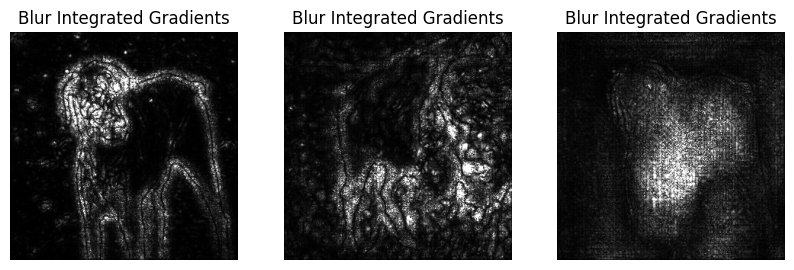

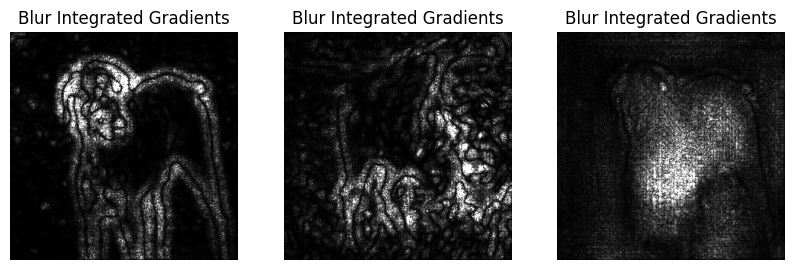

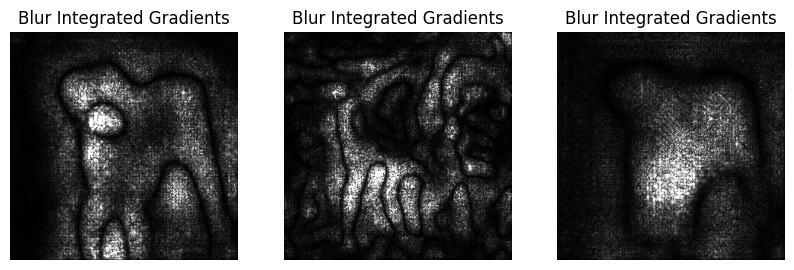

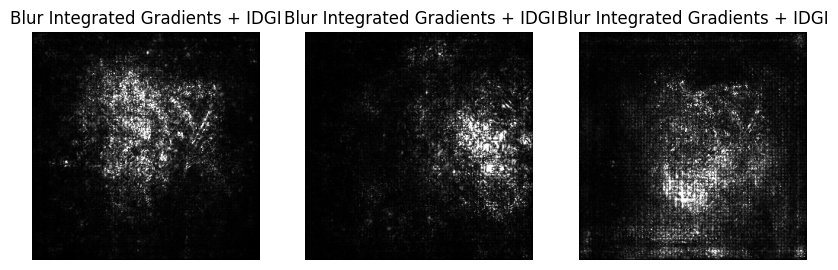

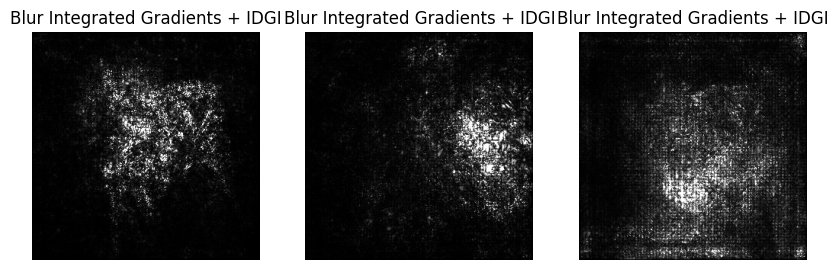

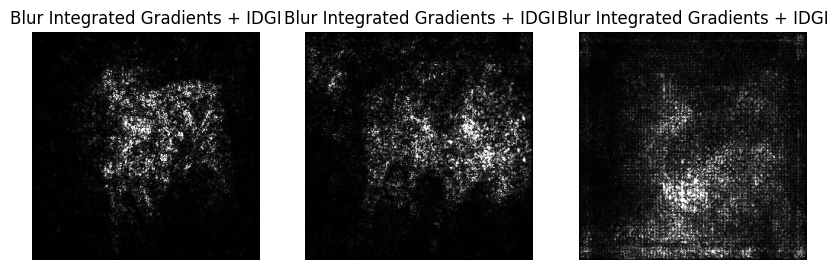

In [ ]:
modelx, loadx, preprocessx = init()
f = BlurIG(modelx, preprocessx, loadx)
blur_ig_mask_3dn, blur_ig_mask_3d_IDGIn = f.saliency(x_values_paths = ['doberman.png', 'bison.png', 'doberman.png'], prediction_class = [236, 347, 83], steps = 20, steps_at = [20, 10,5,2])

print(blur_ig_mask_3dn.shape, blur_ig_mask_3d_IDGIn.shape)

P.figure(figsize=(10,30))
blur_ig_mask_3dl = np.moveaxis(blur_ig_mask_3dn[0],[1,2,3], [3,1,2])
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3dl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3dl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3dl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 3))
P.figure(figsize=(10,30))
blur_ig_mask_3dl = np.moveaxis(blur_ig_mask_3dn[1],[1,2,3], [3,1,2])
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3dl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3dl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3dl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 3))
P.figure(figsize=(10,30))
blur_ig_mask_3dl = np.moveaxis(blur_ig_mask_3dn[2],[1,2,3], [3,1,2])
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3dl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3dl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3dl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients', ax=P.subplot(1, 3, 3))

P.figure(figsize=(10,30))
blur_ig_mask_3d_IDGIl = np.transpose(blur_ig_mask_3d_IDGIn[0],(0,2,3,1))
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 3))
P.figure(figsize=(10,30))
blur_ig_mask_3d_IDGIl = np.transpose(blur_ig_mask_3d_IDGIn[1],(0,2,3,1))
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 3))
P.figure(figsize=(10,30))
blur_ig_mask_3d_IDGIl = np.transpose(blur_ig_mask_3d_IDGIn[2],(0,2,3,1))
blur_ig_mask_grayscalef = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[0])
ShowGrayscaleImage(blur_ig_mask_grayscalef, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 1))
blur_ig_mask_grayscalex = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[1])
ShowGrayscaleImage(blur_ig_mask_grayscalex, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 2))
blur_ig_mask_grayscalec = VisualizeImageGrayscale(blur_ig_mask_3d_IDGIl[2])
ShowGrayscaleImage(blur_ig_mask_grayscalec, title='Blur Integrated Gradients + IDGI', ax=P.subplot(1, 3, 3))

# Read the Following!!!!!!!!
initn ko use karke model wagerah load karo and pass ho jayega. Initn is different from the other init due to blurring

In [ ]:
def show_curve_xy(x, y, title='PIC', label=None, color='blue',
    ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(12, 6))
  auc = np.trapz(y) / y.size
  label = f'{label}, AUC={auc:.3f}'
  ax.plot(x, y, label=label, color=color)
  ax.set_title(title)
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.0])
  ax.legend()


def show_curve(compute_pic_metric_result, title='PIC', label=None, color='blue',
    ax=None):
  show_curve_xy(compute_pic_metric_result.curve_x,
                compute_pic_metric_result.curve_y, title=title, label=label,
                color=color,
                ax=ax)

In [ ]:
import io
import numpy as np
import os
from PIL import Image
from scipy import interpolate
from typing import Callable, List, NamedTuple, Optional, Sequence, Tuple

class ComputePicMetricError(Exception):
  pass

class PicMetricResult(NamedTuple):
  curve_x: Sequence[float]
  curve_y: Sequence[float]
  blurred_images: Sequence[np.ndarray]
  predictions: Sequence[float]
  thresholds: Sequence[float]
  auc: float

def compute_pic_metric(imgs, saliency_map, random_mask, pred_func, saliency_thresholds, min_pred_value = 0.8, keep_monotonous = True, num_data_points = 1000):
  blurred_images = []
  predictions = []
  entropy_pred_tuples = []
  img_t = torch.from_numpy(imgs)
  original_img_entropy = estimate_image_entropy(img_t)
  print(original_img_entropy)
  fully_blurred_img = create_blurred_image(full_img=img_t, pixel_mask=random_mask)
  fully_blurred_img_entropy = estimate_image_entropy(fully_blurred_img)
  print(fully_blurred_img_entropy)
  return
  # Compute model prediction for the original image.
  original_img_pred = pred_func(img_t.unsqueeze(0))[0]

  if original_img_pred < min_pred_value:
    message = ('The model prediction score on the original image is lower than'
               ' `min_pred_value`. Skip this image or decrease the'
               ' value of `min_pred_value` argument. min_pred_value'
               ' = {}, the image prediction'
               ' = {}.'.format(min_pred_value, original_img_pred))
    raise ComputePicMetricError(message)

  fully_blurred_img_pred = pred_func(fully_blurred_img.unsqueeze(0))[0]

  blurred_images.append(fully_blurred_img)
  predictions.append(fully_blurred_img_pred)

  if fully_blurred_img_entropy >= original_img_entropy:
    message = (
        'The entropy in the completely blurred image is not lower than'
        ' the entropy in the original image. Catch the error and exclude this'
        ' image from evaluation. Blurred entropy: {}, original'
        ' entropy {}'.format(fully_blurred_img_entropy, original_img_entropy))
    raise ComputePicMetricError(message)

  if fully_blurred_img_pred >= original_img_pred:
    message = (
        'The model prediction score on the completely blurred image is not'
        ' lower than the score on the original image. Catch the error and'
        ' exclude this image from the evaluation. Blurred score: {}, original'
        ' score {}'.format(fully_blurred_img_pred, original_img_pred))
    raise ComputePicMetricError(message)

  max_normalized_pred = 0.0
  for threshold in saliency_thresholds:
    quantile = np.quantile(saliency_map, 1 - threshold)
    pixel_mask = saliency_map >= quantile
    pixel_mask = np.logical_or(pixel_mask, random_mask)
    blurred_image = create_blurred_image(full_img=img_t, pixel_mask=pixel_mask)
    entropy = estimate_image_entropy(blurred_image)
    pred = pred_func(blurred_image.unsqueeze(0))[0]
    # Normalize the values, so they lie in [0, 1] interval.
    normalized_entropy = (entropy - fully_blurred_img_entropy) / (
        original_img_entropy - fully_blurred_img_entropy)
    normalized_entropy = np.clip(normalized_entropy, 0.0, 1.0)
    normalized_pred = (pred - fully_blurred_img_pred) / (
        original_img_pred - fully_blurred_img_pred)
    normalized_pred = np.clip(normalized_pred, 0.0, 1.0)
    max_normalized_pred = max(max_normalized_pred, normalized_pred)

    # Make normalized_pred only grow if keep_monotonous is true.
    if keep_monotonous:
      entropy_pred_tuples.append((normalized_entropy, max_normalized_pred))
    else:
      entropy_pred_tuples.append((normalized_entropy, normalized_pred))

    blurred_images.append(blurred_image)
    predictions.append(pred)

  # Interpolate the PIC curve.
  entropy_pred_tuples.append((0.0, 0.0))
  entropy_pred_tuples.append((1.0, 1.0))

  entropy_data, pred_data = zip(*entropy_pred_tuples)
  interp_func = interpolate.interp1d(x=entropy_data, y=pred_data)

  curve_x = np.linspace(start=0.0, stop=1.0, num=num_data_points,
                        endpoint=False)
  curve_y = np.asarray([interp_func(x) for x in curve_x])

  curve_x = np.append(curve_x, 1.0)
  curve_y = np.append(curve_y, 1.0)

  auc = np.trapz(curve_y, curve_x)

  blurred_images.append(img)
  predictions.append(original_img_pred)

  thresholds = [0.0] + list(saliency_thresholds) + [1.0]

  return PicMetricResult(curve_x=curve_x, curve_y=curve_y,
                         blurred_images=blurred_images,
                         predictions=predictions, thresholds=thresholds,
                         auc=auc)

class AggregateMetricResult(NamedTuple):
  curve_x: Sequence[float]
  curve_y: Sequence[float]
  auc: float

def aggregate_individual_pic_results(
    compute_pic_metrics_results: List[PicMetricResult],
    method: str = 'median') -> AggregateMetricResult:
  if not compute_pic_metrics_results:
    raise ValueError('The list of results should have at least one element.')

  curve_ys = [r.curve_y for r in compute_pic_metrics_results]
  curve_ys = np.asarray(curve_ys)

  # Validate that x-axis points for all individual results are the same.
  curve_xs = [r.curve_x for r in compute_pic_metrics_results]
  curve_xs = np.asarray(curve_xs)
  _, counts = np.unique(curve_xs, axis=1, return_counts=True)
  if not np.all(counts == 1):
    raise ValueError('Individual results have different x-axis data points.')

  if method == 'mean':
    aggr_curve_y = np.mean(curve_ys, axis=0)
  elif method == 'median':
    aggr_curve_y = np.median(curve_ys, axis=0)
  else:
    raise ValueError('Unknown method {}.'.format(method))

  auc = np.trapz(aggr_curve_y, curve_xs[0])

  return AggregateMetricResult(curve_x=curve_xs[0], curve_y=aggr_curve_y,
                               auc=auc)

In [ ]:
def generate_random_mask(image_height, image_width, fraction=0.01) -> np.ndarray:
  mask = np.zeros(shape=[image_height, image_width], dtype=bool)
  size = mask.size
  indices = np.random.choice(size, replace=False, size=int(size * fraction))
  mask[np.unravel_index(indices, mask.shape)] = True
  return mask

def estimate_image_entropy(images):
  # image == [B, C,H,W]
  buffer = io.BytesIO()
  entropies = []
  for i in range(images.shape[0]):
    pil_image = transforms.ToPILImage()(images[i]).save(buffer, format='webp', lossless=True, quality=100)
    buffer.seek(0, os.SEEK_END)
    length = buffer.tell()
    entropies.append(length)
  buffer.close()
  return torch.tensor(entropies)

def create_blurred_image(full_img, pixel_mask, method = 'linear'):
  pixel_mask_t = pixel_mask
  height = pixel_mask_t.shape[0]
  width = pixel_mask_t.shape[1]
  pixel_mask_t[[0, 0, height - 1, height - 1], [0, width - 1, 0, width - 1]] = True
  mean_color = torch.mean(full_img, dim=(2, 3), dtype = torch.float32).type(torch.uint8)
  if torch.all(pixel_mask_t):
    return full_img
  blurred_img = full_img * pixel_mask_t
  data_points = torch.argwhere(pixel_mask_t[:,:] > 0).cuda()
  unknown_points = torch.argwhere(pixel_mask_t[:,:] == 0).cuda()
  for channel in range(full_img.shape[1]):
    for im in range(full_img.shape[0]):
        data_values = full_img[im,channel,:,:][data_points.T[0],data_points.T[1]]
        interpolated_values = interpolate.griddata(data_points.cpu().numpy(), data_values.cpu().numpy(),
                                                unknown_points.cpu().numpy(), method=method,
                                                fill_value=mean_color[im,channel])
        blurred_img[im, channel, :, :][unknown_points.T[0], unknown_points.T[1]] = torch.from_numpy(interpolated_values.T).type(torch.uint8).cuda()
  return blurred_img

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


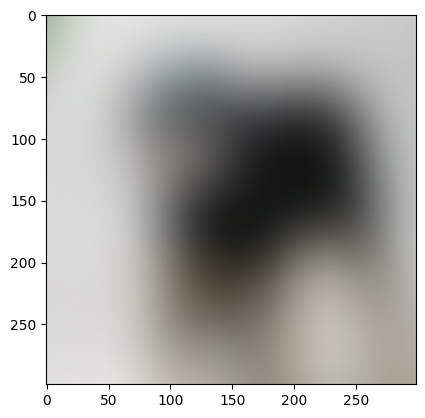

In [ ]:
def load_preprocess (name = "inceptionv3"):
    if(name == "resnet50v2" or name == "resnet101v2" or name == "resnet152v2" or name == "inceptionv3" or name == "mobilenetv2" or name == "vgg16" or name == "vgg19" or name == "densenet121" or name == "densenet169" or name == "densenet201"):
        def PreprocessImages(images):
            transformer = transforms.Compose([
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
            images = torch.tensor(images, dtype = torch.float32)
            images = transformer(images)
            return images.requires_grad_(True)
        return PreprocessImages
def load_model(name = "inceptionv3"):
    model = None
    if(name == "resnet50v2"):
        model = models.resnet50(weights='IMAGENET1K_V2').cuda()
    if(name == "resnet101v2"):
        model = models.resnet101(weights='IMAGENET1K_V2').cuda()
    if(name == "resnet151v2"):
        model = models.resnet152(weights='IMAGENET1K_V2').cuda()
    if(name == "inceptionv3"):
        model = models.inception_v3(weights='IMAGENET1K_V1', init_weights=False).cuda()
    if(name == "mobilenetv2"):
        model = models.mobilenet_v2(weights='IMAGENET1K_V2').cuda()
    if(name == "vgg16"):
        model = models.vgg16(weights='IMAGENET1K_V1').cuda()
    if(name == "vgg19"):
        model = models.vgg19(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet121"):
        model = models.densenet121(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet169"):
        model = models.densenet169(weights='IMAGENET1K_V1').cuda()
    if(name == "densenet201"):
        model = models.densenet201(weights='IMAGENET1K_V1').cuda()
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    model.zero_grad()
    return model
def load_image(name = "inceptionv3"):
    if(name == "resnet50v2" or name == "resnet101v2" or name == "resnet152v2" or name == "mobilenetv2"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(232),
                    transforms.CenterCrop(224)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
    if(name == "inceptionv3"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                im = im.filter(PIL.ImageFilter.GaussianBlur(20))
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(342),
                    transforms.CenterCrop(299)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
    if(name == "vgg16" or name == "vgg19" or name == "densenet121" or name == "densenet169" or name == "densenet201"):
        def LoadImages(file_paths):
            imseq = []
            for file_path in file_paths:
                im = Image.open(file_path)
                transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(256),
                    transforms.CenterCrop(224)
                ])
                im = transformer(im)
                im = im.numpy()
                imseq.append(im)
            return np.asarray(imseq)
        return LoadImages
def initn (name = "inceptionv3"):
    return(load_model(name), load_image(name), load_preprocess(name))

modelx, loadx, preprocessx = initn()

saliency_thresholds = [0.04*i for i in range(26)]
gig_saliency_map = np.abs(np.sum(blur_ig_mask_3dn[0], axis=1))
im_origs = (loadx(['doberman.png', 'bison.png', 'doberman.png'])*255).astype(np.uint8)
P.imshow(np.moveaxis(im_origs[0], [0,1,2], [2,0,1]))
im_orig = im_origs[0]
random_mask = generate_random_mask(image_height=im_orig.shape[1], image_width=im_orig.shape[2], fraction=0.01)
class_idx=[236,347,83]

In [ ]:
def compute_pic_metric(imgs, class_idx, saliency_map, random_mask, pred_func, saliency_thresholds, min_pred_value = 0.8, keep_monotonous = True, num_data_points = 1000):
  blurred_images = []
  predictions = []
  entropy_pred_tuples = []
  img_t = torch.from_numpy(imgs).cuda()
  saliency_map_t = torch.from_numpy(saliency_map).cuda()
  random_mask_t = torch.from_numpy(random_mask).cuda()
  original_img_entropy = estimate_image_entropy(img_t)
  fully_blurred_img = create_blurred_image(full_img=img_t, pixel_mask=random_mask_t)
  fully_blurred_img_entropy = estimate_image_entropy(fully_blurred_img)
  original_img_pred = pred_func(img_t, class_idx)
  fully_blurred_img_pred = pred_func(fully_blurred_img, class_idx)
  blurred_images.append(fully_blurred_img)
  predictions.append(fully_blurred_img_pred)
  max_normalized_pred = 0.0
  for threshold in saliency_thresholds:
    pixel_mask_n = []
    blurred_image_n = []
    for im in range(imgs.shape[0]):
        quantile = torch.quantile(saliency_map_t[im], 1 - threshold)
        pixel_mask = saliency_map_t[im] >= quantile
        pixel_mask = torch.logical_or(pixel_mask, random_mask_t)
        pixel_mask_n.append(pixel_mask)
        blurred_image = create_blurred_image(full_img=img_t[im].unsqueeze(0), pixel_mask=pixel_mask)[0]
        blurred_image_n.append(blurred_image)
    pixel_mask_n = torch.stack(pixel_mask_n)
    blurred_image_n = torch.stack(blurred_image_n)
    entropy = estimate_image_entropy(blurred_image_n)
    pred = pred_func(blurred_image_n, class_idx)
    # Normalize the values, so they lie in [0, 1] interval.
    normalized_entropy = (entropy - fully_blurred_img_entropy) / (
        original_img_entropy - fully_blurred_img_entropy)
    normalized_entropy = np.clip(normalized_entropy, 0.0, 1.0)
    normalized_pred = (pred - fully_blurred_img_pred) / (
        original_img_pred - fully_blurred_img_pred)
    normalized_pred = np.clip(normalized_pred, 0.0, 1.0)
    max_normalized_pred = np.maximum(max_normalized_pred, normalized_pred)
    entropy_pred_tuples.append((normalized_entropy.numpy(), max_normalized_pred))
    blurred_images.append(blurred_image_n)
    predictions.append(pred)
  # Interpolate the PIC curve.
  entropy_pred_tuples.append((np.zeros(imgs.shape[0]), np.zeros(imgs.shape[0])))
  entropy_pred_tuples.append((np.ones(imgs.shape[0]), np.ones(imgs.shape[0])))
  for im in range(imgs.shape[0]):
    entropy_data =  [j[0][im] for j in entropy_pred_tuples]
    pred_data =  [j[1][im] for j in entropy_pred_tuples]
    interp_func = interpolate.interp1d(x=entropy_data, y=pred_data)
    curve_x = np.linspace(start=0.0, stop=1.0, num=num_data_points, endpoint=False)
    curve_y = np.asarray([interp_func(x) for x in curve_x])
    curve_x = np.append(curve_x, 1.0)
    curve_y = np.append(curve_y, 1.0)
    auc = np.trapz(curve_y, curve_x)
    print(auc)

In [ ]:
def pred_func_sic(image_batch, class_idx):
    image_batch = image_batch/255
    #P.imshow(np.moveaxis(image_batch[0].cpu().numpy(), [0,1,2],[2,0,1]))
    #P.show()
    image_batch = preprocessx(image_batch).cuda()
    score = modelx(image_batch)
    m = torch.nn.Softmax(dim=1)
    output = m(score)
    outputs = output[range(0,output.shape[0]),class_idx]
    return outputs.detach().cpu().numpy()

pred_func_sic = create_predict_function_softmax()
gig_result_sic = compute_pic_metric(imgs=im_origs,
                                    class_idx = class_idx,
                                    saliency_map=gig_saliency_map,
                                    random_mask=random_mask,
                                    pred_func=pred_func_sic,
                                    min_pred_value=0.5,
                                    saliency_thresholds=saliency_thresholds,
                                    keep_monotonous=True,
                                    num_data_points=1000)